# Manual Feature Engineering

This notebook shows you how to perform feature engineering using Tensorflow and Keras. Specifically:


*   Defining the model using feature columns
*   Use of Lambda layers to perform feature engineering on some of these features
*   Comparing the training history and predictions of the model before and after feature engineering



In [ ]:
# Import the packages

# Utilities
import os
import logging

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# For modelling
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models

# Set TF logger to only print errors (dismiss warnings)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
if not os.path.isdir("/tmp/data"):
  os.makedirs("./tmp/data")

In [ ]:
!ls

sample_data


In [ ]:
!pwd

/content


In [ ]:
!gsutil cp gs://cloud-training-demos/feat_eng/data/taxi*.csv /tmp/data

Copying gs://cloud-training-demos/feat_eng/data/taxi-test.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-train.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-valid.csv...
- [3 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 3 objects/5.3 MiB.                                      


In [ ]:
!ls -l /tmp/data/*.csv

-rw-r--r-- 1 root root 1113292 Jul 19 17:53 /tmp/data/taxi-test.csv
-rw-r--r-- 1 root root 3551735 Jul 19 17:53 /tmp/data/taxi-train.csv
-rw-r--r-- 1 root root  888648 Jul 19 17:53 /tmp/data/taxi-valid.csv


In [ ]:
pd.read_csv('/tmp/data/taxi-train.csv').head()

,fare_amount,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hourofday,dayofweek
0,8.1,1,-73.973731,40.791910,-73.962737,40.767318,14,4
1,4.5,2,-73.986495,40.739278,-73.986083,40.730933,10,6
2,2.9,1,-73.956043,40.772026,-73.956245,40.773934,22,3
3,7.0,1,-74.006557,40.705797,-73.980017,40.713617,6,3
4,6.5,1,-73.986443,40.741612,-73.990215,40.746467,10,2


In [ ]:
# Specify which column is the target
LABEL_COLUMN = 'fare_amount'

# Specify numerical columns
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
                'hourofday', 'dayofweek']

# A function to separate features and labels
def features_and_labels(row_data):
  label = row_data.pop(LABEL_COLUMN)
  return row_data, label

# A utility method to create a tf.data dataset from a CSV file
def load_dataset(pattern, batch_size=1, mode='eval'):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size)

  dataset = dataset.map(features_and_labels)  # features, label
  if mode == 'train':
    # Notice the repeat method is used so this dataset will loop infinitely
    dataset = dataset.shuffle(1000).repeat()
    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
  return dataset

In [ ]:
def build_dnn_model():
  # Input layer
  inputs = {
      colname: layers.Input(name=colname, shape=(), dtype='float32')
      for colname in NUMERIC_COLS
  }

  # Feature columns
  feature_columns = {
      colname: fc.numeric_column(colname)
      for colname in NUMERIC_COLS
  }

  # Constructor for DenseFeatures takes a list of numeric columns
  # and the resulting tensor takes a dictionary of Input layers
  dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)

  # two hidden layers of 32 and 8 units, respectively
  h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
  h2 = layers.Dense(8, activation='relu', name='h2')(h1)

  # Final output is a linear activation because this is a regression problem
  output = layers.Dense(1, activation='linear', name='fare')(h2)

  model = models.Model(inputs, output)

  # Compile model (MSE is suitable for regression)
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse'])

  return model

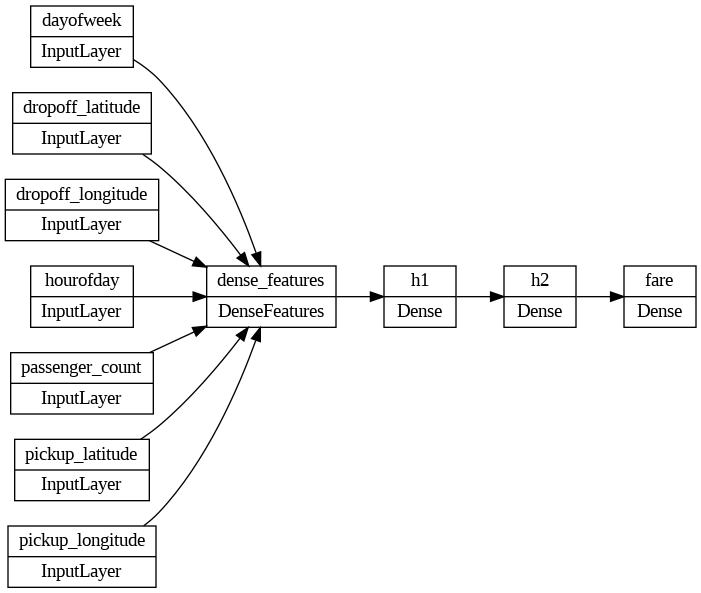

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

# Plot the layer architecture and relationshop between input features
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [ ]:
NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-train.csv'))
NUM_EVAL_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-valid.csv'))

print('NUM_TRAIN_EXAMPLES: ', NUM_TRAIN_EXAMPLES)
print('NUM_EVAL_EXAMPLES: ', NUM_EVAL_EXAMPLES)

NUM_TRAIN_EXAMPLES:  59620
NUM_EVAL_EXAMPLES:  14905


In [ ]:
# Training dataset
trainds = load_dataset('/tmp/data/taxi-train.csv', batch_size=TRAIN_BATCH_SIZE, mode='train')

# Validation dataset
evalds = load_dataset('/tmp/data/taxi-valid.csv', 1000, mode='eval').take(NUM_EVAL_EXAMPLES//1000)

# Needs to be specified since the dataset is infinite
# This happens because the repeat method was used when creating the dataset
steps_per_epoch = NUM_TRAIN_EXAMPLES // TRAIN_BATCH_SIZE

# Train the model and save the history
history = model.fit(trainds, validation_data=evalds, epochs=NUM_EPOCHS, steps_per_epoch=steps_per_epoch)


Epoch 1/20
1863/1863 [==============================] - 8s 3ms/step - loss: 115.5569 - rmse: 10.7497 - mse: 115.5569 - val_loss: 99.3769 - val_rmse: 9.9688 - val_mse: 99.3769
Epoch 2/20
1863/1863 [==============================] - 7s 4ms/step - loss: 105.4322 - rmse: 10.2680 - mse: 105.4322 - val_loss: 101.0930 - val_rmse: 10.0545 - val_mse: 101.0930
Epoch 3/20
1863/1863 [==============================] - 5s 3ms/step - loss: 101.6812 - rmse: 10.0837 - mse: 101.6812 - val_loss: 99.4029 - val_rmse: 9.9701 - val_mse: 99.4029
Epoch 4/20
1863/1863 [==============================] - 6s 3ms/step - loss: 102.1876 - rmse: 10.1088 - mse: 102.1876 - val_loss: 100.5139 - val_rmse: 10.0257 - val_mse: 100.5139
Epoch 5/20
1863/1863 [==============================] - 6s 3ms/step - loss: 103.9367 - rmse: 10.1949 - mse: 103.9367 - val_loss: 101.1327 - val_rmse: 10.0565 - val_mse: 101.1327
Epoch 6/20
1863/1863 [==============================] - 5s 3ms/step - loss: 100.9314 - rmse: 10.0465 - mse: 100.9314

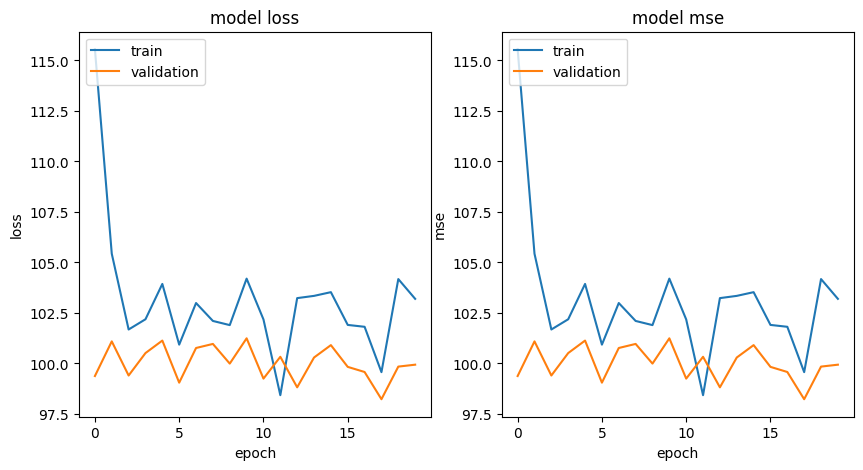

In [ ]:
# Function for plotting metrics for a given history
def plot_curves(history, metrics):
  nrows = 1
  ncols = 2
  fig = plt.figure(figsize=(10,5))

  for idx, key in enumerate(metrics):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history[f'val_{key}'])
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')


# Plot history metrics
plot_curves(history, ['loss', 'mse'])

In [ ]:
# Define a taxi ride (a data point)
taxi_ride = {
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.7588214]),
    'dropoff_longitude': tf.convert_to_tensor([-73.984365]),
    'dropoff_latitude': tf.convert_to_tensor([40.75715]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'hourofday': tf.convert_to_tensor([3.0]),
    'dayofweek': tf.convert_to_tensor([3.0])
}

# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)
print(f'Prediction: {prediction[0]}')

1/1 [==============================] - 1s 575ms/step
Prediction: [10.824277]


In [ ]:
# Drop dayofweek and hourofday features
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

In [ ]:
def scale_longitude(lon_column):
  return (lon_column + 78)/8.

In [ ]:
def scale_latidude(lat_column):
  return (lat_column - 37)/8.

In [ ]:
def euclidean(params):
  lon1, lat1, lon2, lat2 = params
  londiff = lon2 - lon1
  latdiff = lat2 - lat1

  return tf.sqrt(londiff*londiff + latdiff*latdiff)

In [ ]:
def transform(inputs, numeric_cols):

  # Make a copy of the inputs to apply the transformations to
  transformed = inputs.copy()

  # Define feature columns
  feature_columns = {
      colname: tf.feature_column.numeric_column(colname)
      for colname in numeric_cols
  }

  # Scaling longitude from range [-70, -78] to [0, 1]
  for lon_col in ['pickup_longitude', 'dropoff_longitude']:
    transformed[lon_col] = layers.Lambda(
        scale_longitude, name=f"scale_{lon_col}")(inputs[lon_col])

  # Scaling latitude from range [37, 45] to [0, 1]
  for lat_col in ['pickup_latitude', 'dropoff_latitude']:
    transformed[lat_col] = layers.Lambda(
        scale_latidude, name=f"scale_{lat_col}")(inputs[lat_col])

  # add Euclidean distance
  transformed['euclidean'] = layers.Lambda(
      euclidean, name='euclidean')([inputs['pickup_longitude'],
                                    inputs['pickup_latitude'],
                                    inputs['dropoff_longitude'],
                                    inputs['dropoff_latitude']])

  # Add euclidean distance to feature columns
  feature_columns['euclidean'] = fc.numeric_column('euclidean')

  return transformed, feature_columns

In [ ]:
def build_dnn_model():

  # input layer (notice type of float32 since features are numeric)
  inputs = {
      colname: layers.Input(name=colname, shape=(), dtype='float32')
      for colname in NUMERIC_COLS
  }

  # Transfored features
  transformed, feature_columns = transform(inputs, NUMERIC_COLS)

  # Constructor for DenseFeatures takes a list of numeric columns
  # and the resulting tensor takes a dictionary of Lambda layers
  dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

  # two hidden layers of 32 and 8 units, respectively
  h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
  h2 = layers.Dense(8, activation='relu', name='h2')(h1)

  # Final output is a linear activation because this is a regression problem
  output = layers.Dense(1, activation='linear', name='fare')(h2)

  # Create model with inputs and output
  model = models.Model(inputs, output)

  # Compile model (MSE is suitable for regression)
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse'])

  return model

In [ ]:
model = build_dnn_model()

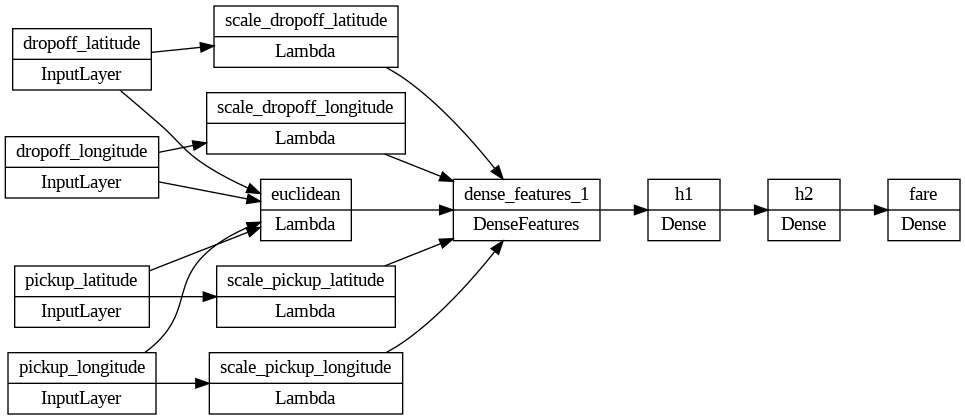

In [ ]:
# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model_engineered.png', show_shapes=False, rankdir='LR')

In [ ]:
# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['passenger_count', 'hourofday', 'dayofweek'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1863/1863 [==============================] - 11s 4ms/step - loss: 105.5239 - rmse: 10.2725 - mse: 105.5239 - val_loss: 84.6708 - val_rmse: 9.2017 - val_mse: 84.6708
Epoch 2/20
1863/1863 [==============================] - 6s 3ms/step - loss: 69.4679 - rmse: 8.3347 - mse: 69.4679 - val_loss: 51.0420 - val_rmse: 7.1444 - val_mse: 51.0420
Epoch 3/20
1863/1863 [==============================] - 8s 4ms/step - loss: 47.6591 - rmse: 6.9036 - mse: 47.6591 - val_loss: 46.4234 - val_rmse: 6.8135 - val_mse: 46.4234
Epoch 4/20
1863/1863 [==============================] - 7s 4ms/step - loss: 47.0194 - rmse: 6.8571 - mse: 47.0194 - val_loss: 48.4211 - val_rmse: 6.9585 - val_mse: 48.4211
Epoch 5/20
1863/1863 [==============================] - 7s 4ms/step - loss: 48.8639 - rmse: 6.9903 - mse: 48.8639 - val_loss: 43.2252 - val_rmse: 6.5746 - val_mse: 43.2252
Epoch 6/20
1863/1863 [==============================] - 6s 3ms/step - loss: 47.8487 - rmse: 6.9173 - mse: 47.8487 - val_loss: 48.1061 - val_rmse: 6

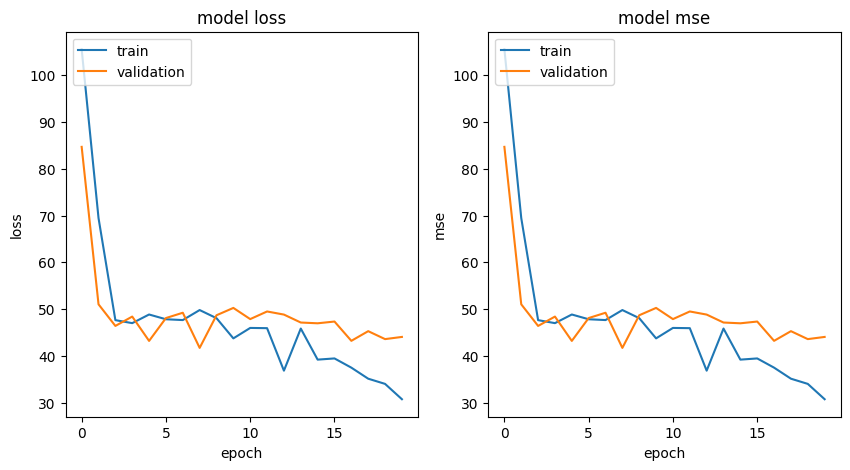

In [ ]:
# Plot history metrics
plot_curves(history, ['loss', 'mse'])

In [ ]:
# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)
print(f'The model predicted a fare total of {float(prediction):.2f}USD for the ride.')

1/1 [==============================] - 0s 38ms/step
The model predicted a fare total of 6.20USD for the ride.


<ipython-input-45-f29757a3dc89>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'The model predicted a fare total of {float(prediction):.2f}USD for the ride.')
